# ARIMA प्रयोग गरेर समय श्रृंखला पूर्वानुमान

यस नोटबुकमा, हामी कसरी गर्ने भनेर देखाउँछौं:
- ARIMA समय श्रृंखला पूर्वानुमान मोडेलको लागि समय श्रृंखला डेटा तयार गर्ने
- समय श्रृंखला मा अगाडि HORIZON चरणहरू (समय *t+1* देखि *t+HORIZON* सम्म) पूर्वानुमान गर्न एक साधारण ARIMA मोडेल कार्यान्वयन गर्ने
- मोडेलको मूल्याङ्कन गर्ने

यस उदाहरणमा प्रयोग गरिएको डेटा GEFCom2014 पूर्वानुमान प्रतियोगिताबाट लिइएको हो। यो २०१२ देखि २०१४ सम्मको ३ वर्षको घण्टाको आधारमा बिजुलीको लोड र तापक्रमको मानहरू समावेश गर्दछ। कार्य भनेको बिजुली लोडको भविष्यका मानहरू पूर्वानुमान गर्नु हो। यस उदाहरणमा, हामीले ऐतिहासिक लोड डेटा मात्र प्रयोग गरेर एक समय चरण अगाडि पूर्वानुमान कसरी गर्ने भनेर देखाएका छौं।

ताओ हङ, पियरे पिन्सन, शु फ्यान, हमिदरेजा जारेइपुर, अल्बर्टो ट्रोक्कोली र रोब जे. हाइन्डम्यान, "संभाव्य ऊर्जा पूर्वानुमान: ग्लोबल ऊर्जा पूर्वानुमान प्रतियोगिता २०१४ र त्यसपछि", इन्टरनेशनल जर्नल अफ फोरकास्टिङ, भोल्युम ३२, नं. ३, पृष्ठ ८९६-९१३, जुलाई-सप्टेम्बर, २०१६।


## आवश्यक निर्भरता स्थापना गर्नुहोस्  
समाधानका लागि आवश्यक केही निर्भरता स्थापना गरेर सुरु गर्नुहोस्। यी पुस्तकालयहरू र तिनीहरूको सम्बन्धित संस्करणहरू समाधानका लागि काम गर्न सक्ने भनेर प्रमाणित गरिएका छन्:  

* `statsmodels == 0.12.2`  
* `matplotlib == 3.4.2`  
* `scikit-learn == 0.24.2`  


In [16]:
!pip install statsmodels

/bin/sh: pip: command not found


In [17]:
import os
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
import math

from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.preprocessing import MinMaxScaler
from common.utils import load_data, mape
from IPython.display import Image

%matplotlib inline
pd.options.display.float_format = '{:,.2f}'.format
np.set_printoptions(precision=2)
warnings.filterwarnings("ignore") # specify to ignore warning messages


In [18]:
energy = load_data('./data')[['load']]
energy.head(10)

load
2012-01-01 00:00:00 2,698.00
2012-01-01 01:00:00 2,558.00
2012-01-01 02:00:00 2,444.00
2012-01-01 03:00:00 2,402.00
2012-01-01 04:00:00 2,403.00
2012-01-01 05:00:00 2,453.00
2012-01-01 06:00:00 2,560.00
2012-01-01 07:00:00 2,719.00
2012-01-01 08:00:00 2,916.00
2012-01-01 09:00:00 3,105.00

सामाग्री उपलब्ध लोड डेटा (जनवरी २०१२ देखि डिसेम्बर २०१४) प्लट गर्नुहोस्


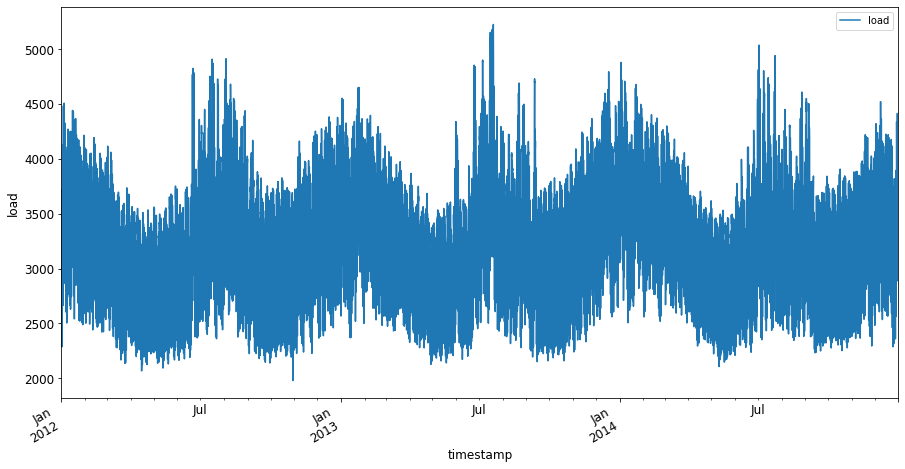

In [19]:
energy.plot(y='load', subplots=True, figsize=(15, 8), fontsize=12)
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('load', fontsize=12)
plt.show()

## प्रशिक्षण र परीक्षण डेटा सेटहरू तयार गर्नुहोस्

### प्रशिक्षण डेटा सेट तयार गर्नुहोस्

प्रशिक्षण डेटा सेटले तपाईंको मोडेललाई विभिन्न प्रकारका इनपुटहरू र तिनीहरूको अपेक्षित आउटपुटहरू बुझ्न मद्दत गर्दछ। यो सुनिश्चित गर्न महत्त्वपूर्ण छ कि डेटा विविध र सन्तुलित छ।

1. **डेटा सङ्कलन गर्नुहोस्**: तपाईंको प्रयोग केससँग सम्बन्धित डेटा सङ्कलन गर्नुहोस्। यो डेटा विभिन्न स्रोतहरूबाट आउन सक्छ, जस्तै प्रयोगकर्ता इनपुट, डेटाबेस, वा सार्वजनिक रूपमा उपलब्ध डेटासेटहरू।

2. **डेटा सफा गर्नुहोस्**: 
   - अनावश्यक वा गलत इनपुटहरू हटाउनुहोस्।
   - डेटा ढाँचा एकरूप बनाउनुहोस्।
   - हराइरहेका मानहरूलाई व्यवस्थापन गर्नुहोस्।

3. **लेबलिङ गर्नुहोस्**: 
   - यदि तपाईंको मोडेललाई सुपरभाइज्ड लर्निङको आवश्यकता छ भने, प्रत्येक इनपुटसँग सम्बन्धित सही आउटपुट (लेबल) प्रदान गर्नुहोस्।
   - उदाहरण: यदि तपाईं स्प्याम डिटेक्टर बनाउँदै हुनुहुन्छ भने, प्रत्येक इमेललाई "स्प्याम" वा "नस्प्याम" भनेर लेबल गर्नुहोस्।

4. **डेटा विभाजन गर्नुहोस्**: 
   - डेटा सेटलाई दुई भागमा विभाजन गर्नुहोस्: प्रशिक्षण र परीक्षण।
   - सामान्यतया, ७०-८०% डेटा प्रशिक्षणका लागि र बाँकी परीक्षणका लागि छुट्याइन्छ।

### परीक्षण डेटा सेट तयार गर्नुहोस्

परीक्षण डेटा सेटले तपाईंको मोडेलको प्रदर्शन मूल्याङ्कन गर्न मद्दत गर्दछ। यो डेटा सेटले मोडेलले पहिले कहिल्यै नदेखेको इनपुटहरू समावेश गर्नुपर्छ।

1. **प्रशिक्षण डेटा सेटबाट अलग राख्नुहोस्**: 
   - परीक्षण डेटा सेटले प्रशिक्षण डेटा सेटसँग ओभरल्याप गर्नु हुँदैन।
   - यो सुनिश्चित गर्न महत्त्वपूर्ण छ कि मोडेलले नयाँ डेटा हेरेर मात्र सिकेको छ।

2. **वास्तविक संसारको परिदृश्यलाई प्रतिबिम्बित गर्नुहोस्**: 
   - परीक्षण डेटा सेटले वास्तविक प्रयोग केसलाई नजिकबाट प्रतिनिधित्व गर्नुपर्छ।
   - विविधता र जटिलता समावेश गर्न निश्चित गर्नुहोस्।

3. **प्रदर्शन मेट्रिक्स परिभाषित गर्नुहोस्**: 
   - परीक्षण डेटा सेट प्रयोग गरेर, तपाईंले मोडेलको सटीकता, पुनःप्राप्ति, र अन्य मेट्रिक्स मापन गर्न सक्नुहुन्छ।

### [!TIP] 
प्रशिक्षण र परीक्षण डेटा सेटहरू तयार गर्दा, डेटा पूर्वाग्रहबाट बच्न प्रयास गर्नुहोस्। पूर्वाग्रहले मोडेलको निष्पक्षता र विश्वसनीयतामा असर गर्न सक्छ। 

### उदाहरण

```python
# उदाहरण कोड: डेटा विभाजन
from sklearn.model_selection import train_test_split

# डेटा लोड गर्नुहोस्
data = load_data()

# प्रशिक्षण र परीक्षण सेटमा विभाजन गर्नुहोस्
train_data, test_data = train_test_split(data, test_size=0.2, random_state=42)

print("प्रशिक्षण डेटा आकार:", len(train_data))
print("परीक्षण डेटा आकार:", len(test_data))
```

### [!IMPORTANT]
प्रशिक्षण र परीक्षण डेटा सेटहरू तयार गर्दा, गोपनीयता र डेटा सुरक्षा नियमहरूको पालना गर्नुहोस्। सुनिश्चित गर्नुहोस् कि तपाईंको डेटा सुरक्षित छ र कुनै पनि संवेदनशील जानकारी खुलासा हुँदैन।


In [20]:
train_start_dt = '2014-11-01 00:00:00'
test_start_dt = '2014-12-30 00:00:00'    

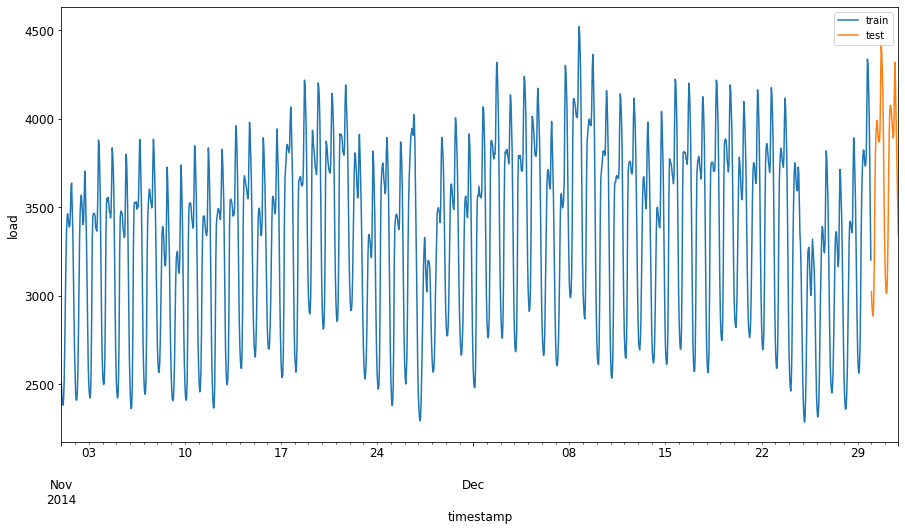

In [21]:
energy[(energy.index < test_start_dt) & (energy.index >= train_start_dt)][['load']].rename(columns={'load':'train'}) \
    .join(energy[test_start_dt:][['load']].rename(columns={'load':'test'}), how='outer') \
    .plot(y=['train', 'test'], figsize=(15, 8), fontsize=12)
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('load', fontsize=12)
plt.show()

In [22]:
train = energy.copy()[(energy.index >= train_start_dt) & (energy.index < test_start_dt)][['load']]
test = energy.copy()[energy.index >= test_start_dt][['load']]

print('Training data shape: ', train.shape)
print('Test data shape: ', test.shape)

Training data shape:  (1416, 1)
Test data shape:  (48, 1)


In [23]:
scaler = MinMaxScaler()
train['load'] = scaler.fit_transform(train)
train.head(10)

load
2014-11-01 00:00:00  0.10
2014-11-01 01:00:00  0.07
2014-11-01 02:00:00  0.05
2014-11-01 03:00:00  0.04
2014-11-01 04:00:00  0.06
2014-11-01 05:00:00  0.10
2014-11-01 06:00:00  0.19
2014-11-01 07:00:00  0.31
2014-11-01 08:00:00  0.40
2014-11-01 09:00:00  0.48

मूल बनाम स्केल गरिएको डेटा:


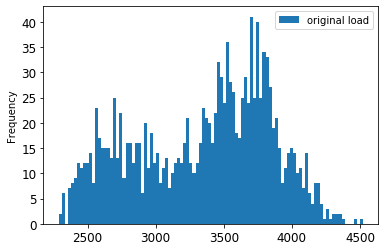

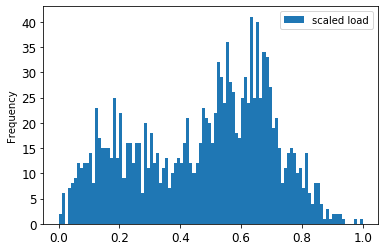

In [24]:
energy[(energy.index >= train_start_dt) & (energy.index < test_start_dt)][['load']].rename(columns={'load':'original load'}).plot.hist(bins=100, fontsize=12)
train.rename(columns={'load':'scaled load'}).plot.hist(bins=100, fontsize=12)
plt.show()

परीक्षण डाटालाई पनि स्केल गरौं।


In [25]:
test['load'] = scaler.transform(test)
test.head()

load
2014-12-30 00:00:00  0.33
2014-12-30 01:00:00  0.29
2014-12-30 02:00:00  0.27
2014-12-30 03:00:00  0.27
2014-12-30 04:00:00  0.30

In [26]:
# Specify the number of steps to forecast ahead
HORIZON = 3
print('Forecasting horizon:', HORIZON, 'hours')

Forecasting horizon: 3 hours


In [27]:
order = (4, 1, 0)
seasonal_order = (1, 1, 0, 24)

model = SARIMAX(endog=train, order=order, seasonal_order=seasonal_order)
results = model.fit()

print(results.summary())


                                     SARIMAX Results                                      
Dep. Variable:                               load   No. Observations:                 1416
Model:             SARIMAX(4, 1, 0)x(1, 1, 0, 24)   Log Likelihood                3477.239
Date:                            Thu, 30 Sep 2021   AIC                          -6942.477
Time:                                    14:36:28   BIC                          -6911.050
Sample:                                11-01-2014   HQIC                         -6930.725
                                     - 12-29-2014                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8403      0.016     52.226      0.000       0.809       0.872
ar.L2         -0.5220      0.034   

प्रत्येक HORIZON चरणको लागि एउटा परीक्षण डेटा बिन्दु सिर्जना गर्नुहोस्।


In [28]:
test_shifted = test.copy()

for t in range(1, HORIZON):
    test_shifted['load+'+str(t)] = test_shifted['load'].shift(-t, freq='H')
    
test_shifted = test_shifted.dropna(how='any')
test_shifted.head(5)

load  load+1  load+2
2014-12-30 00:00:00  0.33    0.29    0.27
2014-12-30 01:00:00  0.29    0.27    0.27
2014-12-30 02:00:00  0.27    0.27    0.30
2014-12-30 03:00:00  0.27    0.30    0.41
2014-12-30 04:00:00  0.30    0.41    0.57

In [29]:
%%time
training_window = 720 # dedicate 30 days (720 hours) for training

train_ts = train['load']
test_ts = test_shifted

history = [x for x in train_ts]
history = history[(-training_window):]

predictions = list()

# let's user simpler model for demonstration
order = (2, 1, 0)
seasonal_order = (1, 1, 0, 24)

for t in range(test_ts.shape[0]):
    model = SARIMAX(endog=history, order=order, seasonal_order=seasonal_order)
    model_fit = model.fit()
    yhat = model_fit.forecast(steps = HORIZON)
    predictions.append(yhat)
    obs = list(test_ts.iloc[t])
    # move the training window
    history.append(obs[0])
    history.pop(0)
    print(test_ts.index[t])
    print(t+1, ': predicted =', yhat, 'expected =', obs)

2014-12-30 00:00:00
1 : predicted = [0.32 0.29 0.28] expected = [0.32945389435989236, 0.2900626678603402, 0.2739480752014323]
2014-12-30 01:00:00
2 : predicted = [0.3  0.29 0.3 ] expected = [0.2900626678603402, 0.2739480752014323, 0.26812891674127126]
2014-12-30 02:00:00
3 : predicted = [0.27 0.28 0.32] expected = [0.2739480752014323, 0.26812891674127126, 0.3025962399283795]
2014-12-30 03:00:00
4 : predicted = [0.28 0.32 0.42] expected = [0.26812891674127126, 0.3025962399283795, 0.40823634735899716]
2014-12-30 04:00:00
5 : predicted = [0.3  0.39 0.54] expected = [0.3025962399283795, 0.40823634735899716, 0.5689346463742166]
2014-12-30 05:00:00
6 : predicted = [0.4  0.55 0.66] expected = [0.40823634735899716, 0.5689346463742166, 0.6799462846911368]
2014-12-30 06:00:00
7 : predicted = [0.57 0.68 0.75] expected = [0.5689346463742166, 0.6799462846911368, 0.7309758281110115]
2014-12-30 07:00:00
8 : predicted = [0.68 0.75 0.8 ] expected = [0.6799462846911368, 0.7309758281110115, 0.75111906893

पूर्वानुमानलाई वास्तविक लोडसँग तुलना गर्नुहोस्


In [30]:
eval_df = pd.DataFrame(predictions, columns=['t+'+str(t) for t in range(1, HORIZON+1)])
eval_df['timestamp'] = test.index[0:len(test.index)-HORIZON+1]
eval_df = pd.melt(eval_df, id_vars='timestamp', value_name='prediction', var_name='h')
eval_df['actual'] = np.array(np.transpose(test_ts)).ravel()
eval_df[['prediction', 'actual']] = scaler.inverse_transform(eval_df[['prediction', 'actual']])
eval_df.head()

timestamp    h  prediction   actual
0 2014-12-30 00:00:00  t+1    3,008.74 3,023.00
1 2014-12-30 01:00:00  t+1    2,955.53 2,935.00
2 2014-12-30 02:00:00  t+1    2,900.17 2,899.00
3 2014-12-30 03:00:00  t+1    2,917.69 2,886.00
4 2014-12-30 04:00:00  t+1    2,946.99 2,963.00

सामान्य भविष्यवाणीहरूको लागि **औसत पूर्ण प्रतिशत त्रुटि (MAPE)** गणना गर्नुहोस्

$$MAPE = \frac{1}{n} \sum_{t=1}^{n}|\frac{actual_t - predicted_t}{actual_t}|$$


In [31]:
if(HORIZON > 1):
    eval_df['APE'] = (eval_df['prediction'] - eval_df['actual']).abs() / eval_df['actual']
    print(eval_df.groupby('h')['APE'].mean())

h
t+1   0.01
t+2   0.01
t+3   0.02
Name: APE, dtype: float64


In [32]:
print('One step forecast MAPE: ', (mape(eval_df[eval_df['h'] == 't+1']['prediction'], eval_df[eval_df['h'] == 't+1']['actual']))*100, '%')

One step forecast MAPE:  0.5570581332313952 %


In [33]:
print('Multi-step forecast MAPE: ', mape(eval_df['prediction'], eval_df['actual'])*100, '%')

Multi-step forecast MAPE:  1.1460048657704118 %


परीक्षण सेटको पहिलो हप्ताको लागि भविष्यवाणीहरू बनाम वास्तविकताहरूको प्लट गर्नुहोस्


No handles with labels found to put in legend.


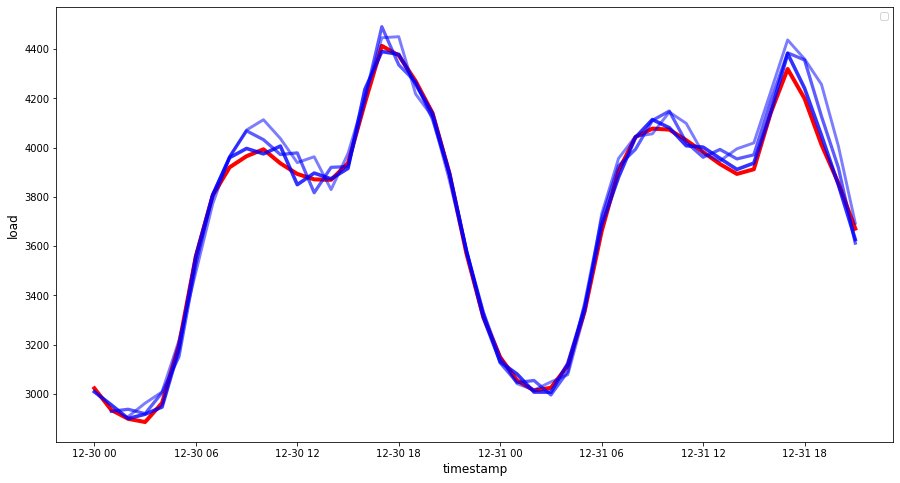

In [34]:
if(HORIZON == 1):
    ## Plotting single step forecast
    eval_df.plot(x='timestamp', y=['actual', 'prediction'], style=['r', 'b'], figsize=(15, 8))

else:
    ## Plotting multi step forecast
    plot_df = eval_df[(eval_df.h=='t+1')][['timestamp', 'actual']]
    for t in range(1, HORIZON+1):
        plot_df['t+'+str(t)] = eval_df[(eval_df.h=='t+'+str(t))]['prediction'].values

    fig = plt.figure(figsize=(15, 8))
    ax = plt.plot(plot_df['timestamp'], plot_df['actual'], color='red', linewidth=4.0)
    ax = fig.add_subplot(111)
    for t in range(1, HORIZON+1):
        x = plot_df['timestamp'][(t-1):]
        y = plot_df['t+'+str(t)][0:len(x)]
        ax.plot(x, y, color='blue', linewidth=4*math.pow(.9,t), alpha=math.pow(0.8,t))
    
    ax.legend(loc='best')
    
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('load', fontsize=12)
plt.show()


---

**अस्वीकरण**:  
यो दस्तावेज़ AI अनुवाद सेवा [Co-op Translator](https://github.com/Azure/co-op-translator) प्रयोग गरेर अनुवाद गरिएको छ। हामी शुद्धताको लागि प्रयास गर्छौं, तर कृपया ध्यान दिनुहोस् कि स्वचालित अनुवादमा त्रुटिहरू वा अशुद्धताहरू हुन सक्छ। यसको मूल भाषा मा रहेको मूल दस्तावेज़लाई आधिकारिक स्रोत मानिनुपर्छ। महत्वपूर्ण जानकारीको लागि, व्यावसायिक मानव अनुवाद सिफारिस गरिन्छ। यस अनुवादको प्रयोगबाट उत्पन्न हुने कुनै पनि गलतफहमी वा गलत व्याख्याको लागि हामी जिम्मेवार हुने छैनौं।
